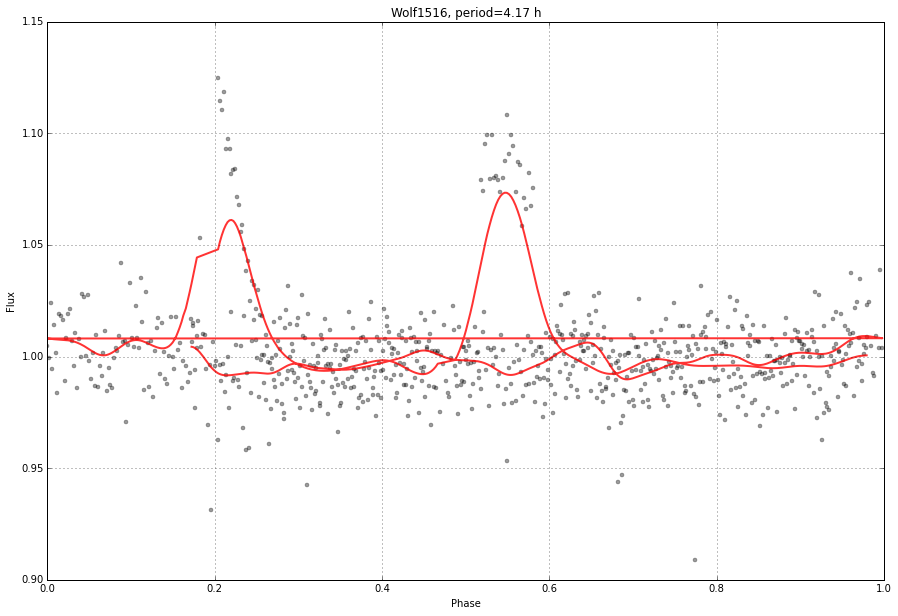

In [5]:
%matplotlib inline
import padre
reload(padre)
from padre import LightCurve
import astropy.units as u
from ipywidgets import interact, FloatSlider, RadioButtons
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np

wolf1516 = LightCurve.load_from('Wolf1516_bestlc.npz', name='Wolf1516')

min_period = 2*u.hour
max_period = 10*u.hour
period_steps = 10*u.min
smooth_kernel = dict(gauss2 = 2,
                     gauss5 = 5, 
                     gauss10 = 10,
                     gauss8 = 8)

period_slider = FloatSlider(min=min_period.to(u.day).value, 
                            max=max_period.to(u.day).value,
                            step=period_steps.to(u.day).value, 
                            value=0.5*(min_period + max_period).to(u.day).value)

smoothing_kernel = RadioButtons(options=smooth_kernel.keys())

# decorate the plot function with an environment from the UIs:
@interact(kernel=smoothing_kernel, period_days=period_slider)
def plot_interactive(period_days, kernel):
    fig, ax = plt.subplots(figsize=(15, 10))
    lc = wolf1516
    t0 = np.mean(lc.times.jd)
    times = ((lc.times.jd - t0) % period_days) / period_days
    fluxes = lc.fluxes
    smoothed_fluxes = gaussian_filter(lc.fluxes, smooth_kernel[kernel])
    
    ax.grid()
    ax.plot(times, fluxes, 'ko', markersize=4, alpha=0.4)
    ax.plot(times, smoothed_fluxes, 'r', lw=2, alpha=0.8)
    ax.set(xlabel='Phase', ylabel='Flux',
           title="{0}, period={1:.2f}".format(lc.name, 
                                              (period_days*u.day).to(u.hour)))
